# Preliminary EDA

### An Advanced Persistent Threat (APT) is a type of cyber attack where an attacker gains unauthorized access to a network and remains undetected for an extended period of time. The goal of an APT is usually to steal sensitive information or to disrupt critical systems. APT attacks are usually carried out by well-funded and highly skilled attackers, such as nation-state actors or organized criminal groups.

### The objective of this project is to identify an APT and determine remedial actions

In [2]:
## Import Functions and Spark Config
from pyspark.sql.functions import sum
from pyspark.sql.functions import avg
from pyspark.sql.functions import desc
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
%run ./read_file.ipynb

:: loading settings :: url = jar:file:/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ec2-user/.ivy2/cache
The jars for the packages stored in: /home/ec2-user/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ac1f95d6-2408-4e70-8e30-c58c1703bac2;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 255ms :: artifacts dl 4ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	-----------------------------

23/03/11 00:35:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/11 00:35:35 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


## Set Environment

In [3]:
# env - dev / prod
# size - small / medium / large
env='prod'
size='medium'


## Part 1: Load Data

#### Load bro data (Network Data)

In [4]:
# df_bro = readCheckpoint('bro', env)

In [ ]:
df_bro.printSchema()

#### Business Glossary for Network Data

| Column Name   | Description                                                                                   |
|---------------|-----------------------------------------------------------------------------------------------|
| ts            | Timestamp                                                           |
| uid           | A unique identifier for each connection                                                        |
| id.orig_h     | IP address of the host that initiated the connection                                          |
| id.orig_p     | Port number used by the host that initiated the connection                                     |
| id.resp_h     | IP address of the host that received the connection                                            |
| id.resp_p     | Port number used by the host that received the connection                                      |
| proto         | Network protocol used for the connection (e.g. TCP, UDP)                                       |
| service       | Service used for the connection (e.g. http, ftp)                                               |
| duration      | Length of time (in seconds) that the connection was active                                     |
| orig_bytes    | Number of bytes transmitted by the host that initiated the connection                         |
| resp_bytes    | Number of bytes transmitted by the host that received the connection                          |
| conn_state    | Current state of the connection                                                               |
| local_orig    | Indicates whether the connection was initiated by a local host                                |
| local_resp    | Indicates whether the connection was received by a local host                                 |
| missed_bytes  | Number of bytes that were lost during transmission                                             |
| history       | Record of the connection history                                                              |
| orig_pkts     | Number of packets transmitted by the host that initiated the connection                       |
| orig_ip_bytes | Number of IP bytes transmitted by the host that initiated the connection                       |
| resp_pkts     | Number of packets transmitted by the host that received the connection                        |
| resp_ip_bytes | Number of IP bytes transmitted by the host that received the connection                        |
| tunnel_parents| Identifies any parent connections for the connection (if any)                                  |


#### Load ecarbro data (Link Data between records in the ecar stream and bro tables)

In [5]:
df_ecarbro = readCheckpoint('ecar-bro', env)

 4:29AM UTC on Mar 06, 2023 --- read and cache time: 8.570740938186646 seconds ---


In [6]:
df_ecarbro.printSchema()

root
 |-- id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- objectID: string (nullable = true)
 |-- actorID: string (nullable = true)
 |-- object: string (nullable = true)
 |-- action: string (nullable = true)
 |-- hostname: string (nullable = true)



#### Business Glossary for Link Data


| Column Name  | Description                                                                                     |
|--------------|-------------------------------------------------------------------------------------------------|
| action       | Action performed in the event                                                                   |
| actorID      | Unique ID of the actor who performed the action                                                 |
| hostname     | Hostname of the system where the action was performed                                           |
| id           | ID associated with the event                                                                    |
| object       | Object related to the event                                                                     |
| objectID     | Unique ID of the object related to the event                                                    |
| pid          | Process ID associated with the event                                                            |
| ppid         | Parent process ID associated with the event                                                     |
| principal    | Principal associated with the event                                                              |
| tid          | Thread ID associated with the event                                                              |
| timestamp    | Time when the event occurred                                                                    |
| acuity_level | Acuity level associated with the event                                                           |
| bro_uid      | Bro unique identifier associated with the event                                                 |
| dest_ip      | IP address of the destination of the event                                                       |
| dest_port    | Port number of the destination of the event                                                      |
| direction    | Direction of the event (inbound/outbound)                                                        |
| image_path   | Path of the image associated with the event                                                      |
| l4protocol   | Layer 4 protocol used in the event                                                               |
| src_ip       | IP address of the source of the event                                                            |
| src_port     | Port number of the source of the event                                                           |
| event_minute| Minute of the event
| event_day| Day of the event
| event_hour| Hour of the event

#### Load ecar data (Endpoint Data, e.g. PC, Smartphone, Router, IOT device, etc.)

In [1]:
df_ecar = readCheckpoint('ecar', env, size).cache()

In [ ]:
df_ecar.printSchema()

root
 |-- id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- objectID: string (nullable = true)
 |-- actorID: string (nullable = true)
 |-- object: string (nullable = true)
 |-- action: string (nullable = true)
 |-- hostname: string (nullable = true)



| Field          | Definition                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
|----------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| action         | The type of action taken, e.g. START, MODIFY, etc.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| actorID        | The ID of the actor responsible for the action.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| hostname       | The hostname of the device where the action occurred.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| id             | The ID of the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| object         | The object associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| objectID       | The ID of the object associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| pid            | The process ID associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| ppid           | The parent process ID associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
| principal      | The user or account associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| tid            | The thread ID associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| timestamp      | The timestamp of the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| acuity_level   | The severity of the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| base_address   | The base address of the object associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| command_line   | The command line associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| context_info   | Additional context information associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| data           | Additional data associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| dest_port      | The destination port associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| direction      | The direction of the event (e.g. inbound/outbound).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
| end_time       | The end time of the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| file_path      | The file path associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| image_path     | The image path associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| info_class     | The information class associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| key            | The registry key associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| l4protocol     | The layer 4 protocol associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| logon_id       | The logon ID associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| module_path    | The module path associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| new_path       | The new path associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| parent_image_path | The parent image path associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| path           | The path associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
| payload        | The payload associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| privileges     | The privileges associated with the event.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| requesting_domain | The domain of the account that made the request.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
| requesting_logon_id | The logon ID of the account
| stack_base | The base address of the stack for the thread that generated the event |
| stack_limit | The limit of the stack for the thread that generated the event |
| start_address | The starting address of the process that generated the event |
| start_time | The time at which the process that generated the event started |
| subprocess_tag | A unique tag that identifies the subprocess that generated the event |
| task_name | The name of the task that generated the event |
| task_pid | The process ID of the task that generated the event |
| task_process_uuid | The UUID of the process that generated the event |
| tgt_pid | The process ID of the target of the event |
| tgt_pid_uuid | The UUID of the target process of the event |
| tgt_tid | The thread ID of the target of the event |
| type | The type of event that was generated |
| user | The user associated with the event |
| user_name | The name of the user associated with the event |
| user_stack_base | The base address of the stack for the user associated with the event |
| user_stack_limit | The limit of the stack for the user associated with the event |
| value | The value associated with the event |
| event_day | The day on which the event occurred |
| event_hour | The hour at which the event occurred |
| event_minute | The minute at which the event occurred |


## Part 2: EDA

#### Network Data (bro)

In [13]:
# Count the number of rows in the DataFrame
print('Total number of rows:', df_bro.count())

# update column names from period to underscore
df_bro = df_bro.withColumnRenamed("id.orig_h", "id_orig_h") \
               .withColumnRenamed("id.orig_p", "id_orig_p") \
               .withColumnRenamed("id.resp_", "id_resp_h") \
               .withColumnRenamed("id.resp_p", "id_resp_p")

# Show the first 5 rows of the DataFrame
df_bro.limit(5).toPandas()

NameError: name 'df_bro' is not defined

In [14]:
# Describe the numerical columns of the DataFrame
description = df_bro.select('duration', 'orig_bytes', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes').describe()

# Convert the describe dataframe to a pandas dataframe
pandas_df = description.toPandas()

# Set the index to the statistics
pandas_df.set_index('summary', inplace=True)

# Print the pandas dataframe
print(pandas_df)



NameError: name 'df_bro' is not defined

In [26]:
# Group the DataFrame by protocol and count the number of occurrences for each protocol
print("\033[1mCommentary:\033[0m A protocol is like a set of rules that computers use to talk to each other and send information over the internet. Think of it like a secret code that helps the computers understand each other and send the right information. In our data, we see different types of protocols and will investigate if any protocol is more conducive to malicious activity.")
df_bro.groupBy('proto').count().orderBy(desc('count')).show()

# Group the DataFrame by service and count the number of occurrences for each service
print("\033[1mCommentary:\033[0m Services are used by computers to communicate with each other over the internet.")
df_bro.groupBy('service').count().orderBy(desc('count')).show()

# Find the top 5 host pairs with the highest number of connections
print("\033[1mCommentary:\033[0m Top 5 host pairs with the highest number of connections")
df_bro.groupBy('id_orig_h', 'id_resp_h').count().orderBy(desc('count')).show(5)

# Find the total number of bytes sent and received for each host
print("\033[1mCommentary:\033[0m Total number of bytes sent and received for each host")
df_bro.groupBy('id_orig_h')\
      .agg(sum('orig_bytes').alias('total_orig_bytes'), \
           sum('resp_bytes').alias('total_resp_bytes'))\
      .orderBy('total_orig_bytes', ascending=False)\
      .show()

# Find the average duration of connections for each service
print("\033[1mCommentary:\033[0m Average duration of connections for each service")
df_bro.groupBy('service').agg(avg('duration').alias('avg_duration')).orderBy(desc('avg_duration')).show()


Commentary: A protocol is like a set of rules that computers use to talk to each other and send information over the internet. Think of it like a secret code that helps the computers understand each other and send the right information. In our data, we see different types of protocols and will investigate if any protocol is more conducive to malicious activity.
+-----+------+
|proto| count|
+-----+------+
|  tcp|995775|
|  udp|  4202|
| icmp|    23|
+-----+------+

Commentary: Services are used by computers to communicate with each other over the internet.
+--------+------+
| service| count|
+--------+------+
|     ssl|942229|
|    http| 49922|
|     dns|  4198|
|       -|  3065|
|ssl,smtp|   315|
|smtp,ssl|   271|
+--------+------+

Commentary: Top 5 host pairs with the highest number of connections
+-------------+------------+-----+
|    id_orig_h|   id_resp_h|count|
+-------------+------------+-----+
|142.20.57.186|165.101.35.5| 9159|
| 142.20.56.17|165.101.35.5| 5659|
|142.20.59.10

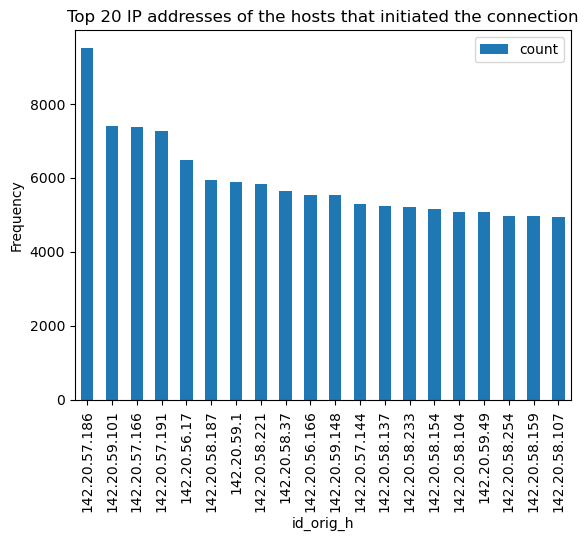

In [32]:
# Group by the data by id_orig_h and count, then sort count
id_orig_h_counts = df_bro.groupBy('id_orig_h').agg(F.count('id_orig_h').alias('count')).orderBy('count', ascending=False)

# Select the top 20 values and output to a Pandas dataframe
top_20_id_orig_h = id_orig_h_counts.limit(20).toPandas()

# Plot a histogram of the top 20 id_orig_h values
top_20_id_orig_h.plot(kind='bar', x='id_orig_h', y='count')

# set the title and axis labels
plt.title('Top 20 IP addresses of the hosts that initiated the connection')
plt.xlabel('Host IP')
plt.ylabel('Frequency')

# display the plot
plt.show()


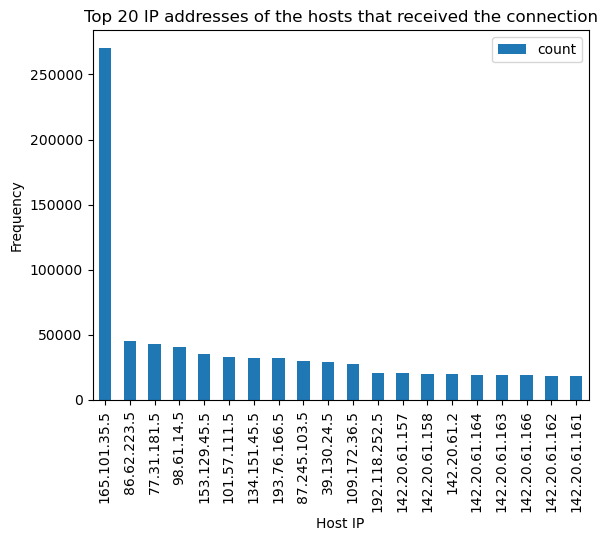

In [33]:
# Group by the data by id_resp_h and count, then sort count
id_resp_h_counts = df_bro.select('id_resp_h').groupBy('id_resp_h').count().orderBy(desc('count'))

# select the top 20 values
top_20_id_resp_h = id_resp_h_counts.limit(20).toPandas()

# plot a histogram of the top 20 id_resp_h values
top_20_id_resp_h.plot(kind='bar', x='id_resp_h', y='count')

# set the title and axis labels
plt.title('Top 20 IP addresses of the hosts that received the connection')
plt.xlabel('Host IP')
plt.ylabel('Frequency')

# display the plot
plt.show()



#### Link Data (ecarbro)

In [19]:
# Count the number of rows in the DataFrame
print('Total number of rows:', df_ecarbro.count())

# Show the first 5 rows of the DataFrame
df_ecarbro.limit(5).toPandas()

Total number of rows: 175840


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,action,actorID,hostname,id,object,objectID,pid,ppid,principal,tid,...,dest_ip,dest_port,direction,image_path,l4protocol,src_ip,src_port,event_minute,event_day,event_hour
0,INFO,c446795c-b73f-458a-9175-dfdfe19f7266,SysClient0003.systemia.com,94734cc3-2451-47b2-887a-3194affc2384,FLOW,18124da7-1115-4f2c-9628-cc91927fd8dd,3708,1760,SYSTEMIACOM\wcaldwell,-1,...,None,NaN,None,None,None,None,NaN,0,23,18
1,INFO,c446795c-b73f-458a-9175-dfdfe19f7266,SysClient0003.systemia.com,3b96029d-81dd-4dbd-b218-5960dea386d2,FLOW,8fd457f9-3ff4-439e-8a3c-cff43a4c81ed,3708,1760,SYSTEMIACOM\wcaldwell,-1,...,None,NaN,None,None,None,None,NaN,0,23,18
2,INFO,c446795c-b73f-458a-9175-dfdfe19f7266,SysClient0003.systemia.com,f1992ec6-05b5-4d53-8f52-4a83d31aacab,FLOW,81c5860c-030b-441c-84ab-e4cd113129b5,3708,1760,SYSTEMIACOM\wcaldwell,-1,...,None,NaN,None,None,None,None,NaN,0,23,18
3,INFO,c446795c-b73f-458a-9175-dfdfe19f7266,SysClient0003.systemia.com,290fbc4d-87ed-4fdc-817c-6f29b6ff1f6a,FLOW,0a799da7-37b3-4f6a-9acb-1ca908464a68,3708,1760,SYSTEMIACOM\wcaldwell,-1,...,None,NaN,None,None,None,None,NaN,0,23,18
4,INFO,c446795c-b73f-458a-9175-dfdfe19f7266,SysClient0003.systemia.com,51619eb9-3932-4196-b3e6-945b7aa4001b,FLOW,18434bf4-f39d-4fcd-9cc4-1b8bd436dd3a,3708,1760,SYSTEMIACOM\wcaldwell,-1,...,None,NaN,None,None,None,None,NaN,0,23,18


In [20]:
# Types of object/action pairs and their count

df_ecarbro.groupBy("object","action").count().show()

+------+------+------+
|object|action| count|
+------+------+------+
|  FLOW|  INFO|175840|
+------+------+------+



#### Endpoint Data (ecarbro)

In [38]:
# Count the number of rows in the DataFrame
pd.options.display.max_columns = None
print('Total number of rows:', df_ecar.count())

# Show the first 5 rows of the DataFrame
df_ecar.limit(5).toPandas()

Total number of rows: 1000000


,action,actorID,hostname,id,object,objectID,pid,ppid,principal,tid,timestamp,acuity_level,base_address,command_line,context_info,data,dest_port,direction,end_time,file_path,image_path,info_class,key,l4protocol,logon_id,module_path,new_path,parent_image_path,path,payload,privileges,requesting_domain,requesting_logon_id,requesting_user,sid,size,src_ip,src_pid,src_port,src_tid,stack_base,stack_limit,start_address,start_time,subprocess_tag,task_name,task_pid,task_process_uuid,tgt_pid,tgt_pid_uuid,tgt_tid,type,user,user_name,user_stack_base,user_stack_limit,value,event_day,event_hour,event_minute
0,START,43c9a912-533a-475c-b3c4-2bfb93892dfd,SysClient0024.systemia.com,66f12aed-8a6f-48b9-a244-3ff5b1da593f,FLOW,7992ee1d-96c2-4afc-8ff9-3a19c7c4e760,916,-1,,NaN,NaT,None,None,None,None,None,NaN,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,NaT,None,None,NaN,None,NaN,None,NaN,None,None,None,None,None,None,NaN,NaN,NaN
1,START,c9d2265d-1868-4a7f-9767-73b6724b4b77,SysClient0009.systemia.com,89d45da5-12e5-44f6-919f-454839185072,FLOW,3fea8024-1873-4b74-9521-4fe0b4be9afa,912,-1,,NaN,NaT,None,None,None,None,None,NaN,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,NaT,None,None,NaN,None,NaN,None,NaN,None,None,None,None,None,None,NaN,NaN,NaN
2,START,43c9a912-533a-475c-b3c4-2bfb93892dfd,SysClient0024.systemia.com,134be215-040e-4afc-8f90-8d6ec5abee29,FLOW,ecb96be3-d831-4a25-ab13-05e6f0b9763a,916,-1,,NaN,NaT,None,None,None,None,None,NaN,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,NaT,None,None,NaN,None,NaN,None,NaN,None,None,None,None,None,None,NaN,NaN,NaN
3,START,c9d2265d-1868-4a7f-9767-73b6724b4b77,SysClient0009.systemia.com,fa37801b-659b-4d4a-9edb-cd889db96343,FLOW,5dae789f-6b8b-4beb-ab74-9226cc6a1ef0,912,-1,,NaN,NaT,None,None,None,None,None,NaN,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,NaT,None,None,NaN,None,NaN,None,NaN,None,None,None,None,None,None,NaN,NaN,NaN
4,START,43c9a912-533a-475c-b3c4-2bfb93892dfd,SysClient0024.systemia.com,c6e12392-1d80-4c29-aa31-654d409be012,FLOW,4c653859-dce3-4879-9961-28f588eb262e,916,-1,,NaN,NaT,None,None,None,None,None,NaN,None,NaT,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,NaT,None,None,NaN,None,NaN,None,NaN,None,None,None,None,None,None,NaN,NaN,NaN


In [13]:
# Types of object/action pairs and their count

df_ecar.groupBy("object", "action").count().orderBy(desc("count")).show()

+------+------+-------+
|object|action|  count|
+------+------+-------+
|  FLOW|  INFO|1000000|
+------+------+-------+



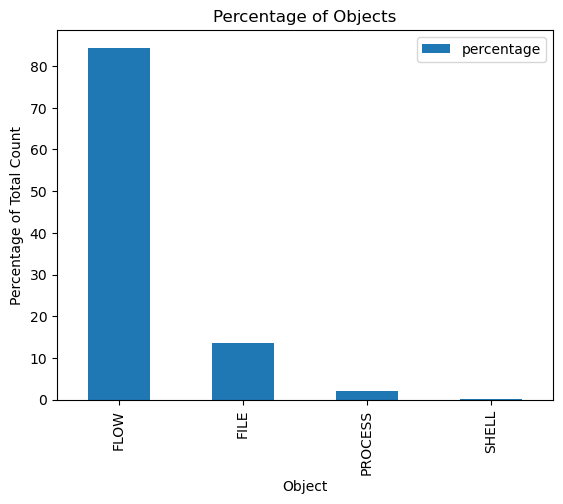

In [41]:
# Group and aggregate data
df_grouped = df_ecar.groupBy("object").agg(F.count("*").alias("count"))

# Calculate percentage of total count
total_count = df_grouped.agg(F.sum("count")).collect()[0][0]
df_grouped = df_grouped.withColumn("percentage", F.round((F.col("count")/total_count)*100, 2))

# Order by count
df_grouped = df_grouped.orderBy(desc("count"))

# Convert PySpark DataFrame to Pandas DataFrame
df_pd = df_grouped.toPandas()

# Plot bar chart
df_pd.plot(x='object', y='percentage', kind='bar')
plt.xlabel('Object')
plt.ylabel('Percentage of Total Count')
plt.title('Percentage of Objects')
plt.show()


In [13]:
# Create new column for user/application
df_ecar = df_ecar.withColumn('user_or_app', F.when(F.col('user').isNull(), 'Application').otherwise('User'))

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df_ecar.groupBy("user_or_app").count().orderBy(desc("count")).toPandas()

# Plot bar chart
pandas_df.plot(kind="bar", x="user_or_app", y="count")
plt.show()



ConnectionRefusedError: [Errno 111] Connection refused

In [48]:
# Calculate the object and actorID pairs relative to the total number of events

# Compute total count of events
total_count = df_ecar.count()

# Group by object and actorID, and count the number of events
df_grouped = df_ecar.groupBy("object", "actorID").agg(F.count("*").alias("count"))

# Calculate percentage of total count
df_grouped = df_grouped.withColumn("percentage", F.round((F.col("count")/total_count)*100, 2))

# Order by count in descending order and display top 5
df_top_5 = df_grouped.orderBy(F.desc("count")).limit(5)

# Show the result
df_top_5.show()

+------+--------------------+-----+----------+
|object|             actorID|count|percentage|
+------+--------------------+-----+----------+
|  FLOW|dc638440-c1e5-4bf...|44750|      4.48|
|  FLOW|5dfd694f-adf6-45d...|31934|      3.19|
|  FLOW|45b62774-dc52-4ca...|27036|       2.7|
|  FLOW|cc3fed27-1902-426...|20784|      2.08|
|  FLOW|7a4d2279-2d4b-431...|20160|      2.02|
+------+--------------------+-----+----------+



In [35]:
from pyspark.sql.functions import col

# Filter the dataframe where l4protocol is not null and display the first 5 rows
df_ecar.filter(col("l4protocol").isNotNull()).show(5)

+------+-------+--------+---+------+--------+---+----+---------+---+---------+------------+------------+------------+------------+----+---------+---------+--------+---------+----------+----------+---+----------+--------+-----------+--------+-----------------+----+-------+----------+-----------------+-------------------+---------------+---+----+------+-------+--------+-------+----------+-----------+-------------+----------+--------------+---------+--------+-----------------+-------+------------+-------+----+----+---------+---------------+----------------+-----+---------+----------+------------+
|action|actorID|hostname| id|object|objectID|pid|ppid|principal|tid|timestamp|acuity_level|base_address|command_line|context_info|data|dest_port|direction|end_time|file_path|image_path|info_class|key|l4protocol|logon_id|module_path|new_path|parent_image_path|path|payload|privileges|requesting_domain|requesting_logon_id|requesting_user|sid|size|src_ip|src_pid|src_port|src_tid|stack_base|stack_limi

#### Label Data

In [5]:
#df_labels = readCheckpoint('labels', env, size)
df_labels = readCheckpoint_bcm('labels')

10:55PM UTC on Mar 09, 2023 --- read and cache time: 1.6450881958007812e-05 seconds ---


In [6]:
df_ecar.limit(5).toPandas()

NameError: name 'df_ecar' is not defined

In [7]:
df_labels.limit(5).toPandas()

,hostname,id,objectID,actorID,timestamp,object,action
0,SysClient0201.systemia.com,43fb9623-3cd1-45ec-ab22-dbe46e75240e,96913629-c1c9-4503-9586-4a91de0e7311,af6b49d5-f648-41a4-946d-d92b174bae47,2019-09-23T11:23:55.857-04:00,PROCESS,CREATE
1,SysClient0201.systemia.com,78fccbc8-58d1-4598-ae21-99f57ee57ed8,b53c1986-842c-493a-910c-78b55da2575f,96913629-c1c9-4503-9586-4a91de0e7311,2019-09-23T11:25:26.418-04:00,SHELL,COMMAND
2,SysClient0201.systemia.com,fb89e8be-47a1-418c-9bb8-a4c702694c74,b53c1986-842c-493a-910c-78b55da2575f,96913629-c1c9-4503-9586-4a91de0e7311,2019-09-23T11:25:26.416-04:00,SHELL,COMMAND
3,SysClient0201.systemia.com,05e5bde3-8db5-410a-ad75-de676bd14ebb,b53c1986-842c-493a-910c-78b55da2575f,96913629-c1c9-4503-9586-4a91de0e7311,2019-09-23T11:25:26.436-04:00,SHELL,COMMAND
4,SysClient0201.systemia.com,1bdb7482-a548-40f2-b648-ea258e6c2448,b53c1986-842c-493a-910c-78b55da2575f,96913629-c1c9-4503-9586-4a91de0e7311,2019-09-23T11:25:26.434-04:00,SHELL,COMMAND


In [20]:
# Create a new dataframe with distinct objectIDs to identify malcious ObjectIds
df_malcious_objectIDs = df_labels.select('id').distinct()

# Create a new column called 'malicious' in df_ecar to label malicious records
df_ecar = df_ecar.withColumn('malicious', when(col('id').isin(df_malcious_objectIDs.rdd.flatMap(lambda x: x).collect()), 1).otherwise(0))

In [21]:
# Filter the rows where malicious column equals 1 to test code 
df_malicious = df_ecar.filter(col('malicious') == 1)

# Show 5 malicous records
df_malicious.limit(5).toPandas()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,id,timestamp,objectID,actorID,object,action,hostname,malicious
0,e361c4b8-de66-4c15-8525-17d819ce855d,2019-09-23 15:31:08.522,44b31f0d-7a69-4031-90de-5bacc521938f,a52f6519-6265-4437-9f6c-3402fb245cc7,SHELL,COMMAND,SysClient0201.systemia.com,1
1,987a5ad7-e502-474c-9403-ea2360b880ba,2019-09-23 15:31:08.523,44b31f0d-7a69-4031-90de-5bacc521938f,a52f6519-6265-4437-9f6c-3402fb245cc7,SHELL,COMMAND,SysClient0201.systemia.com,1
2,35db42d9-7b81-4670-a549-0d4a1d5474c8,2019-09-23 15:31:08.526,44b31f0d-7a69-4031-90de-5bacc521938f,a52f6519-6265-4437-9f6c-3402fb245cc7,SHELL,COMMAND,SysClient0201.systemia.com,1
3,788f2164-f53f-461e-bc92-360da7c68703,2019-09-23 15:31:08.527,44b31f0d-7a69-4031-90de-5bacc521938f,a52f6519-6265-4437-9f6c-3402fb245cc7,SHELL,COMMAND,SysClient0201.systemia.com,1
4,24f2f923-f099-4d9d-9e0b-8dba052daeab,2019-09-23 15:31:13.667,44b31f0d-7a69-4031-90de-5bacc521938f,a52f6519-6265-4437-9f6c-3402fb245cc7,SHELL,COMMAND,SysClient0201.systemia.com,1


In [22]:
# Filter the rows where malicious column equals 0 to test code
df_non_malicious = df_ecar.filter(col('malicious') == 0)

# Show 5 malicous records
df_non_malicious.limit(5).toPandas()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,id,timestamp,objectID,actorID,object,action,hostname,malicious
0,fbea6675-4397-4189-b8ef-76b8e9a4a726,2019-09-23 15:33:00.321,4249f4db-106f-4439-93cd-44ef97eabc6b,6b2883bf-2851-49ba-b30c-e342e5710fbd,FILE,CREATE,SysClient0066.systemia.com,0
1,3c843dbc-a027-459a-bae7-de588f21d7c9,2019-09-23 15:33:01.411,a4c90607-1cdd-41f2-9a98-408c58122341,4e733055-c663-4823-8d48-4ab1defb97dc,FLOW,INFO,SysClient0116.systemia.com,0
2,9d7af6e0-3f80-4432-8de1-00a638f3de03,2019-09-23 15:33:00.007,95530c9a-9088-464c-9b57-043787bdbd8c,b2e4fa76-67f4-4d78-b136-86f3b63cf5aa,PROCESS,OPEN,SysClient0057.systemia.com,0
3,6ebe4aa7-3ac7-4d29-a0e5-9e2d20b3894f,2019-09-23 15:33:01.441,28d680f7-7bbd-4327-8635-3035686313b3,4e733055-c663-4823-8d48-4ab1defb97dc,FLOW,INFO,SysClient0116.systemia.com,0
4,ed8bdf7c-6c43-4956-8ed1-009c42469d99,2019-09-23 15:33:00.227,d36946ba-34ed-4c91-8099-338400dce1f0,c5868956-b7af-4373-a9cc-d41608f11e2a,FILE,MODIFY,SysClient0055.systemia.com,0


In [ ]:
source is actorid, destination is objectid



In [27]:
from graphframes import GraphFrame

# Create distinct vertices with source as actorid, destination as objectid
src_vertices = df_ecar.selectExpr('actorID as id').distinct()
dst_vertices = df_ecar.selectExpr('objectID as id').distinct()
vertices = src_vertices.union(dst_vertices).distinct()

# Create edges by using timestamp as an edge
edges = df_ecar.selectExpr('actorID as src', 'objectID as dst', 'timestamp')

# Create GraphFrame
g = GraphFrame(vertices, edges)

In [28]:
# display the vertices
print("Vertices:")
g.vertices.show()

# display the edges
print("Edges:")
g.edges.show()

Vertices:
23/03/05 17:53:21 ERROR Executor: Exception in task 39.0 in stage 47.0 (TID 1837)
java.io.FileNotFoundException: 
No such file or directory: s3a://sapient-bucket-refined/prod/ecar/medium/event_day=23/event_hour=13/event_minute=22/part-00000-ebd3d2f8-6297-4672-9283-316d7cb49014.c000.snappy.parquet

It is possible the underlying files have been updated. You can explicitly invalidate
the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by
recreating the Dataset/DataFrame involved.
       
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:648)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:212)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:270)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala

Py4JJavaError: An error occurred while calling o140031.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 39 in stage 47.0 failed 1 times, most recent failure: Lost task 39.0 in stage 47.0 (TID 1837) (ip-172-16-66-18.us-west-2.compute.internal executor driver): java.io.FileNotFoundException: 
No such file or directory: s3a://sapient-bucket-refined/prod/ecar/medium/event_day=23/event_hour=13/event_minute=22/part-00000-ebd3d2f8-6297-4672-9283-316d7cb49014.c000.snappy.parquet

It is possible the underlying files have been updated. You can explicitly invalidate
the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by
recreating the Dataset/DataFrame involved.
       
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:648)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:212)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:270)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:116)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:553)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.hasNext(InMemoryRelation.scala:118)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1508)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1435)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1499)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1322)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:376)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:327)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.io.FileNotFoundException: 
No such file or directory: s3a://sapient-bucket-refined/prod/ecar/medium/event_day=23/event_hour=13/event_minute=22/part-00000-ebd3d2f8-6297-4672-9283-316d7cb49014.c000.snappy.parquet

It is possible the underlying files have been updated. You can explicitly invalidate
the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by
recreating the Dataset/DataFrame involved.
       
	at org.apache.spark.sql.errors.QueryExecutionErrors$.readCurrentFileNotFoundError(QueryExecutionErrors.scala:648)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:212)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:270)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:116)
	at org.apache.spark.sql.execution.FileSourceScanExec$$anon$1.hasNext(DataSourceScanExec.scala:553)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.columnartorow_nextBatch_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.columnar.DefaultCachedBatchSerializer$$anon$1.hasNext(InMemoryRelation.scala:118)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1508)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1435)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1499)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1322)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:376)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:327)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)


In [ ]:
g.inDegrees.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/networkx/drawing/layout.py:548: RuntimeWarning: divide by zero encountered in true_divide
  "ijk,ij->ik", delta, (k * k / distance**2 - A * distance / k)


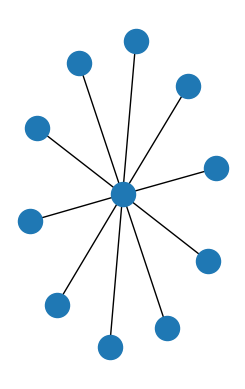

In [9]:
# Stackoverflow: https://stackoverflow.com/questions/54204062/how-to-display-visualize-a-graph-created-by-graphframe

import networkx as nx
from graphframes import GraphFrame

def PlotGraph(edge_list):
    Gplot=nx.Graph()
    for row in edge_list.select('src','dst').take(10):
        Gplot.add_edge(row['src'],row['dst'])

    plt.subplot(121)
    nx.draw(Gplot)
    
    
PlotGraph(g.edges)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Get vertices and edges DataFrames
vertices = g.vertices.toPandas()
edges = g.edges.toPandas()

# Convert vertices and edges DataFrames to NetworkX graph
nx_graph = nx.from_pandas_edgelist(edges, 'src', 'dst', create_using=nx.DiGraph())
nx_graph.add_nodes_from(vertices['id'])

# Draw the graph using Matplotlib
pos = nx.spring_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True)
plt.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/networkx/drawing/layout.py:625: RuntimeWarning: divide by zero encountered in true_divide
  delta * (k * k / distance**2 - Ai * distance / k)


#### Build Agency Graph

In [4]:
%run ./read_file.ipynb 

In [5]:
def build_adjaceny(df, dataset = 'ecar'):
    
    start_time = time.time()
    
    if dataset == 'labels':
        df = df.sort(col("ts2").asc())
    else : 
        #first step sort the data and check
        df = df.sort(col("timestamp").asc())
    
    #now get overlapping connections

    #build collections of each type of ID
    #TODO make this one select statement
    col_objID = df.select("objectID").distinct().collect()
    col_actID = df.select("actorID").distinct().collect()
    
    print(len(col_actID))

    #put these columns into a dictionary and turn into a spark data frame
    data = [{"actorIDs" : [row.actorID for row in col_actID], \
                   "objectIDs" : [row.objectID for row in col_objID]}]

    id_intersect = spark.createDataFrame(data)

    #compare ID pools to find actIDs that are nodes
    id_intersect = id_intersect.withColumn("id_int", \
                                           array_intersect(col("actorIDs"),col("objectIDs")))

    #now build a list of the nodal actIDs and print the length
    actIDs = [row.id_int for row in id_intersect.select("id_int").collect()][0]
    
    print("length actIDs: "+str(len(actIDs)))
    print("elapsed time: "+ str(time.time() - start_time))
    #create ref dict
    dict_node_edge_events = {}
    count = 0 
    
    #for all actors in actIDs
    for aID in actIDs: 
        
        birth_event = df.where((col("objectID") == aID) \
                               & (col("actorID")!= aID)).limit(1).collect()
        
        if len(birth_event) > 0: 
            first_id = birth_event[0]['id']

            #now add this to the dictionary as a key
            first_event = str(aID+':'+first_id)
            dict_node_edge_events[first_event] = []

            #now add all the events where the actorID is present but not the objectID, group by unique object ID
            #and pull out the first event - and I checked and believe the sorting holds through grouping
            col_select_children_events = df.select('objectID','id')\
            .where((col("actorID") == aID) & \
                     (col("objectID") != aID)).groupBy("objectID").agg(first("id")).collect() 

            #add children objects into dictioinary 
            dict_node_edge_events[first_event] = [str(row["objectID"]+':'+row["first(id)"]) for row in col_select_children_events]
        else:
            count += 1
    
    print("no birth event for " + str(count)+" events.")
    
    # create a list of tuples from the dictionary
    data_list = list(dict_node_edge_events.items())

    # convert the list of tuples to a PySpark RDD
    data_rdd = spark.sparkContext.parallelize(data_list)

    # create a PySpark DataFrame from the RDD
    df_final = data_rdd.toDF()
    
    #explode list into column, keeping position for some sort of rank just in case
    df_final_exp = df_final.select("_1",posexplode("_2"))
    df_final_exp_col = df_final_exp.selectExpr("_1 as parent", "pos as order", "col as child")
    
    print("elapsed time 2: "+ str(time.time() - start_time))
    return df_final_exp_col

In [6]:
df_labels = readCheckpoint_bcm('labels')
#create a timestamp column and drop the old timestamp - does not appear necessary
df_labels = df_labels.withColumn('ts2', to_timestamp(col('timestamp'))).drop('timestamp')
print('event count' + str(df_labels.count()))
#check new col data types
df_labels.printSchema()

12:35AM UTC on Mar 11, 2023 --- read and cache time: 1.6450881958007812e-05 seconds ---


event count292367
root
 |-- hostname: string (nullable = true)
 |-- id: string (nullable = true)
 |-- objectID: string (nullable = true)
 |-- actorID: string (nullable = true)
 |-- object: string (nullable = true)
 |-- action: string (nullable = true)
 |-- ts2: timestamp (nullable = true)



In [7]:
#run code with labels dataframe
df_labels_adj = build_adjaceny(df_labels, 'labels')

150


length actIDs: 90
elapsed time: 2.7630774974823
no birth event for 0 events.
elapsed time 2: 30.785664796829224


In [8]:
df_labels_adj.limit(5).show()

+--------------------+-----+--------------------+
|              parent|order|               child|
+--------------------+-----+--------------------+
|d5846376-9596-428...|    0|000401b2-4413-4f2...|
|d5846376-9596-428...|    1|00263384-6151-407...|
|d5846376-9596-428...|    2|0093031c-0521-4e7...|
|d5846376-9596-428...|    3|00979bf4-65da-491...|
|d5846376-9596-428...|    4|00accb8e-39bf-40c...|
+--------------------+-----+--------------------+



In [9]:
df_labels_adj.limit(1).collect()[0]['parent']

'd5846376-9596-4283-8505-8e6112abf1f2:e15537fe-fdb0-49d4-a1fd-de34e8215617'

In [10]:
# split parent and child fields to get objectids and eventids

from pyspark.sql.functions import split

df_labels_adj = df_labels_adj.withColumn("parent_objectid", split(df_labels_adj["parent"], ":")[0])
df_labels_adj = df_labels_adj.withColumn("parent_eventid", split(df_labels_adj["parent"], ":")[1])
df_labels_adj = df_labels_adj.withColumn("child_objectid", split(df_labels_adj["child"], ":")[0])
df_labels_adj = df_labels_adj.withColumn("child_eventid", split(df_labels_adj["child"], ":")[1])



In [11]:
df_labels_adj.limit(5).toPandas()

,parent,order,child,parent_objectid,parent_eventid,child_objectid,child_eventid
0,d5846376-9596-4283-8505-8e6112abf1f2:e15537fe-...,0,000401b2-4413-4f26-9943-75877fd855df:3b7351a9-...,d5846376-9596-4283-8505-8e6112abf1f2,e15537fe-fdb0-49d4-a1fd-de34e8215617,000401b2-4413-4f26-9943-75877fd855df,3b7351a9-abe1-4e29-a7dc-18c0aafdb68c
1,d5846376-9596-4283-8505-8e6112abf1f2:e15537fe-...,1,00263384-6151-407f-a38e-6f2c423610b8:a4ecbb2c-...,d5846376-9596-4283-8505-8e6112abf1f2,e15537fe-fdb0-49d4-a1fd-de34e8215617,00263384-6151-407f-a38e-6f2c423610b8,a4ecbb2c-e24d-46df-892f-db41b0b48bc2
2,d5846376-9596-4283-8505-8e6112abf1f2:e15537fe-...,2,0093031c-0521-4e72-a4a1-69840fb738c5:dcede018-...,d5846376-9596-4283-8505-8e6112abf1f2,e15537fe-fdb0-49d4-a1fd-de34e8215617,0093031c-0521-4e72-a4a1-69840fb738c5,dcede018-9ca8-499b-a71f-c8e3446bf19e
3,d5846376-9596-4283-8505-8e6112abf1f2:e15537fe-...,3,00979bf4-65da-4911-a4f5-a1f56a1b20bb:6b7d1a66-...,d5846376-9596-4283-8505-8e6112abf1f2,e15537fe-fdb0-49d4-a1fd-de34e8215617,00979bf4-65da-4911-a4f5-a1f56a1b20bb,6b7d1a66-75d2-46da-9135-9d73bf6e7b9e
4,d5846376-9596-4283-8505-8e6112abf1f2:e15537fe-...,4,00accb8e-39bf-40c0-8d52-4abe7aac5f64:4b7b2f74-...,d5846376-9596-4283-8505-8e6112abf1f2,e15537fe-fdb0-49d4-a1fd-de34e8215617,00accb8e-39bf-40c0-8d52-4abe7aac5f64,4b7b2f74-723c-4728-84a7-ae1ca87a9959


In [12]:
from graphframes import GraphFrame

# Create distinct vertices with source as actorid, destination as objectid
src_vertices = df_labels_adj.selectExpr('parent_objectid as id').distinct()
dst_vertices = df_labels_adj.selectExpr('child_objectid as id').distinct()
vertices = src_vertices.union(dst_vertices).distinct()

# Create edges by using timestamp as an edge
edges = df_labels_adj.selectExpr('parent_objectid as src', 'child_objectid as dst', 'child_eventid')

# Create GraphFrame
g = GraphFrame(vertices, edges)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [13]:
# display the vertices
print("Vertices:")
g.vertices.show()

# display the edges
print("Edges:")
g.edges.show()

Vertices:
+--------------------+
|                  id|
+--------------------+
|b9955edc-eccc-494...|
|d5846376-9596-428...|
|6bb11cd4-bb6c-49c...|
|4a3392b6-acc8-4c2...|
|1106edff-d104-48c...|
|d0c2c702-a256-46b...|
|c2730252-3ab3-40f...|
|64c0966e-66f8-452...|
|8916c2f9-2179-4e6...|
|27aec587-671d-4e6...|
|72fd4fed-89f1-499...|
|bff0865c-96aa-4fb...|
|96913629-c1c9-450...|
|473d7954-6271-43b...|
|b6ddb414-05b7-43c...|
|15357384-f34d-4ff...|
|9cd219ed-ecc9-442...|
|2d02ab42-4400-404...|
|054df7d9-801e-49d...|
|91cf6eed-6ee7-43a...|
+--------------------+
only showing top 20 rows

Edges:
+--------------------+--------------------+--------------------+
|                 src|                 dst|       child_eventid|
+--------------------+--------------------+--------------------+
|d5846376-9596-428...|000401b2-4413-4f2...|3b7351a9-abe1-4e2...|
|d5846376-9596-428...|00263384-6151-407...|a4ecbb2c-e24d-46d...|
|d5846376-9596-428...|0093031c-0521-4e7...|dcede018-9ca8-499...|
|d5846376-9596-

In [12]:
g.inDegrees.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+--------------------+--------+
|                  id|inDegree|
+--------------------+--------+
|1f1621b3-29fa-4a4...|       1|
|78cc15e6-f0f5-452...|       1|
|adecaad5-5d90-44c...|       1|
|bacc46d9-d2ba-403...|       1|
|dca08133-628f-4ff...|       1|
|0b033ccb-53d8-41d...|       1|
|189ccab8-1c95-46b...|       1|
|68856534-2f9a-471...|       1|
|8c5444f3-c33f-4fd...|       1|
|8e3ae437-58a6-42f...|       1|
|a8b3ca65-c915-410...|       1|
|229c828f-fe77-4cc...|       1|
|3c26a28f-6f6c-44b...|       1|
|c4c7fc08-406c-4c6...|       1|
|40afcf64-5fad-48b...|       1|
|8a7a7c79-93d7-4d8...|       1|
|b569c7c2-be7a-455...|       1|
|0fdc5360-36ae-4dd...|       1|
|1d83724a-0c5f-44a...|       1|
|6581c3bd-94f3-48e...|       1|
+--------------------+--------+
only showing top 20 rows



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/networkx/drawing/layout.py:553: RuntimeWarning: divide by zero encountered in true_divide
  delta_pos = np.einsum("ij,i->ij", displacement, t / length)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/networkx/drawing/layout.py:548: RuntimeWarning: divide by zero encountered in true_divide
  "ijk,ij->ik", delta, (k * k / distance**2 - A * distance / k)


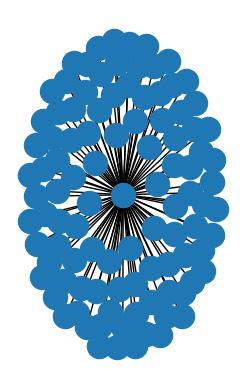

In [35]:
# Stackoverflow: https://stackoverflow.com/questions/54204062/how-to-display-visualize-a-graph-created-by-graphframe

import networkx as nx
from graphframes import GraphFrame

def PlotGraph(edge_list):
    Gplot=nx.Graph()
    for row in edge_list.select('src','dst').take(100):
        Gplot.add_edge(row['src'],row['dst'])

    plt.subplot(121)
    nx.draw(Gplot)
    
    
PlotGraph(g.edges)

In [13]:
g.inDegrees.orderBy("inDegree", ascending=False).show()

+--------------------+--------+
|                  id|inDegree|
+--------------------+--------+
|b15e00e9-e286-483...|       7|
|337b2a67-296e-433...|       7|
|02904fc8-2825-4ed...|       6|
|b865bab2-f482-43d...|       6|
|e7e9e82f-b4dc-45d...|       6|
|2113944a-3da7-497...|       6|
|3e111ee0-3167-4c2...|       6|
|371dd713-1e8c-4d0...|       6|
|6ddd691e-30f4-4bf...|       6|
|f19156c4-3ec4-47f...|       6|
|bbf83587-f890-455...|       6|
|4831e4ec-79b4-4d0...|       6|
|142d959c-693f-4a8...|       6|
|0fcfb540-495f-439...|       6|
|4ca53370-eb3a-46d...|       6|
|9f17b17e-5f0a-4f8...|       6|
|a7408fe6-a5e2-486...|       6|
|1ccc1417-a469-49f...|       6|
|6bc73e9b-444c-4a4...|       6|
|66cd9f21-e63b-49f...|       6|
+--------------------+--------+
only showing top 20 rows



In [15]:
g.outDegrees.orderBy("outDegree", ascending=False).show()

+--------------------+---------+
|                  id|outDegree|
+--------------------+---------+
|054df7d9-801e-49d...|     6256|
|a52f6519-6265-443...|     5328|
|f247d0d1-6ce4-4f8...|     4491|
|266392d7-012e-479...|     4490|
|9211f414-ef00-4aa...|     4488|
|c2730252-3ab3-40f...|     4487|
|3a3de01b-44d0-4a1...|     4484|
|a80f73dc-5713-460...|     4480|
|60f28094-a2f7-49e...|     4120|
|281edc04-1ee7-4f6...|     3319|
|e490633e-4e82-4bb...|     2558|
|3eea9071-9ceb-468...|     1417|
|d359ffa5-8bf5-4f1...|     1343|
|0c38ecf1-faac-446...|     1195|
|d057ca93-553e-46f...|     1159|
|ee99fcf7-84fa-49f...|     1154|
|83279f19-6af6-453...|     1154|
|bff0865c-96aa-4fb...|     1145|
|70ba4f9c-e27b-4a3...|     1144|
|d5846376-9596-428...|     1139|
+--------------------+---------+
only showing top 20 rows



In [27]:
results = g.triangleCount()
results.select("id", "count").show()

+--------------------+-----+
|                  id|count|
+--------------------+-----+
|b9955edc-eccc-494...|  168|
|d5846376-9596-428...|    0|
|6bb11cd4-bb6c-49c...|    0|
|4a3392b6-acc8-4c2...|    0|
|1106edff-d104-48c...|    0|
|d0c2c702-a256-46b...|    0|
|c2730252-3ab3-40f...|    0|
|64c0966e-66f8-452...|    0|
|8916c2f9-2179-4e6...|  337|
|27aec587-671d-4e6...|   11|
|72fd4fed-89f1-499...|    0|
|bff0865c-96aa-4fb...|    0|
|96913629-c1c9-450...|    0|
|473d7954-6271-43b...|    0|
|b6ddb414-05b7-43c...|    0|
|15357384-f34d-4ff...|    0|
|9cd219ed-ecc9-442...|    0|
|2d02ab42-4400-404...|    0|
|054df7d9-801e-49d...|  275|
|91cf6eed-6ee7-43a...|  106|
+--------------------+-----+
only showing top 20 rows



In [59]:
from graphframes import *
import pyspark.sql.functions as F

# find connected edges
connected_edges = g.find("(a)-[]->(b); (b)-[]->(c); (c)-[]->(d); (d)-[]->(e); (e)-[]->(f)")

# display six connected edges
connected_edges.select(F.col("a.id"), F.col("b.id"), F.col("c.id"), F.col("d.id"), F.col("e.id"), F.col("f.id")).toPandas()


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


,id,id,id,id,id,id
0,b9955edc-eccc-4948-8c2f-4cc6608c1e27,8916c2f9-2179-4e6a-bfa0-483a26c6ae6d,054df7d9-801e-49d0-b8cd-4f20b42a4305,91cf6eed-6ee7-43aa-a2d0-62e81ca89e2e,443c9039-ae6b-41a8-ba53-a197d0ce57e9,fb64aa05-c24f-415d-aa14-dcd9c58d90ba
1,b9955edc-eccc-4948-8c2f-4cc6608c1e27,8916c2f9-2179-4e6a-bfa0-483a26c6ae6d,054df7d9-801e-49d0-b8cd-4f20b42a4305,91cf6eed-6ee7-43aa-a2d0-62e81ca89e2e,443c9039-ae6b-41a8-ba53-a197d0ce57e9,fb265837-47f3-41ca-a191-6fd891960c7d
2,b9955edc-eccc-4948-8c2f-4cc6608c1e27,8916c2f9-2179-4e6a-bfa0-483a26c6ae6d,054df7d9-801e-49d0-b8cd-4f20b42a4305,91cf6eed-6ee7-43aa-a2d0-62e81ca89e2e,443c9039-ae6b-41a8-ba53-a197d0ce57e9,e7e9e82f-b4dc-45d7-96ef-042f514c7922
3,b9955edc-eccc-4948-8c2f-4cc6608c1e27,8916c2f9-2179-4e6a-bfa0-483a26c6ae6d,054df7d9-801e-49d0-b8cd-4f20b42a4305,91cf6eed-6ee7-43aa-a2d0-62e81ca89e2e,443c9039-ae6b-41a8-ba53-a197d0ce57e9,e1fd3179-46d9-431c-a697-d21805b9e714
4,b9955edc-eccc-4948-8c2f-4cc6608c1e27,8916c2f9-2179-4e6a-bfa0-483a26c6ae6d,054df7d9-801e-49d0-b8cd-4f20b42a4305,91cf6eed-6ee7-43aa-a2d0-62e81ca89e2e,443c9039-ae6b-41a8-ba53-a197d0ce57e9,dd2f5060-2516-459b-ba6f-473488e3e429
...,...,...,...,...,...,...
20846,3eea9071-9ceb-468a-ad89-9e3890833e52,4aec5900-4572-4d09-81e6-fbc227a7f58d,3eea9071-9ceb-468a-ad89-9e3890833e52,4aec5900-4572-4d09-81e6-fbc227a7f58d,3eea9071-9ceb-468a-ad89-9e3890833e52,01576e70-ec1f-4f07-8c19-0104cccb8561
20847,3eea9071-9ceb-468a-ad89-9e3890833e52,4aec5900-4572-4d09-81e6-fbc227a7f58d,3eea9071-9ceb-468a-ad89-9e3890833e52,4aec5900-4572-4d09-81e6-fbc227a7f58d,3eea9071-9ceb-468a-ad89-9e3890833e52,01178a88-4974-4a9e-b224-c8b29967e302
20848,3eea9071-9ceb-468a-ad89-9e3890833e52,4aec5900-4572-4d09-81e6-fbc227a7f58d,3eea9071-9ceb-468a-ad89-9e3890833e52,4aec5900-4572-4d09-81e6-fbc227a7f58d,3eea9071-9ceb-468a-ad89-9e3890833e52,00f1b836-719b-4c45-bdc8-e6233ce5cffd
20849,3eea9071-9ceb-468a-ad89-9e3890833e52,4aec5900-4572-4d09-81e6-fbc227a7f58d,3eea9071-9ceb-468a-ad89-9e3890833e52,4aec5900-4572-4d09-81e6-fbc227a7f58d,3eea9071-9ceb-468a-ad89-9e3890833e52,00d26d32-947b-4374-90e9-557c2e4332d4


In [63]:
import pandas as pd
from pyspark.sql.functions import *
from graphframes import *

# find all paths of length 6 in the graph
paths = g.find("(a)-[ab]->(b); (b)-[bc]->(c); (c)-[cd]->(d); (d)-[de]->(e); (e)-[ef]->(f)")

# filter paths to only those where all edges are connected
connected_paths = paths.filter("ab.dst = bc.src and bc.dst = cd.src and cd.dst = de.src and de.dst = ef.src")

# get the 6 edges in each path and convert to a pandas dataframe
connected_paths.select("ab", "bc", "cd", "de", "ef").toPandas()



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


,ab,bc,cd,de,ef
0,"(0c38ecf1-faac-4464-8905-ca951cc96f32, e152d28...","(e152d28f-5add-4799-8e46-d65f6fa599cf, 89d8a0b...","(89d8a0b2-5b72-402a-b50a-66f596583f53, 4986cc3...","(4986cc39-9cde-46cf-a6b1-d851afe7b42f, 0c38ecf...","(0c38ecf1-faac-4464-8905-ca951cc96f32, 00714b7..."
1,"(0c38ecf1-faac-4464-8905-ca951cc96f32, e152d28...","(e152d28f-5add-4799-8e46-d65f6fa599cf, 89d8a0b...","(89d8a0b2-5b72-402a-b50a-66f596583f53, 4986cc3...","(4986cc39-9cde-46cf-a6b1-d851afe7b42f, 0c38ecf...","(0c38ecf1-faac-4464-8905-ca951cc96f32, 00832b6..."
2,"(0c38ecf1-faac-4464-8905-ca951cc96f32, e152d28...","(e152d28f-5add-4799-8e46-d65f6fa599cf, 89d8a0b...","(89d8a0b2-5b72-402a-b50a-66f596583f53, 4986cc3...","(4986cc39-9cde-46cf-a6b1-d851afe7b42f, 0c38ecf...","(0c38ecf1-faac-4464-8905-ca951cc96f32, 00be128..."
3,"(0c38ecf1-faac-4464-8905-ca951cc96f32, e152d28...","(e152d28f-5add-4799-8e46-d65f6fa599cf, 89d8a0b...","(89d8a0b2-5b72-402a-b50a-66f596583f53, 4986cc3...","(4986cc39-9cde-46cf-a6b1-d851afe7b42f, 0c38ecf...","(0c38ecf1-faac-4464-8905-ca951cc96f32, 00cd1b7..."
4,"(0c38ecf1-faac-4464-8905-ca951cc96f32, e152d28...","(e152d28f-5add-4799-8e46-d65f6fa599cf, 89d8a0b...","(89d8a0b2-5b72-402a-b50a-66f596583f53, 4986cc3...","(4986cc39-9cde-46cf-a6b1-d851afe7b42f, 0c38ecf...","(0c38ecf1-faac-4464-8905-ca951cc96f32, 00f99e3..."
...,...,...,...,...,...
20846,"(f5d1c003-1f65-4a8a-ba8c-413da99d70f2, a52f651...","(a52f6519-6265-4437-9f6c-3402fb245cc7, f5d1c00...","(f5d1c003-1f65-4a8a-ba8c-413da99d70f2, a52f651...","(a52f6519-6265-4437-9f6c-3402fb245cc7, f5d1c00...","(f5d1c003-1f65-4a8a-ba8c-413da99d70f2, a52f651..."
20847,"(d0c2c702-a256-46be-9f95-f33e16feff24, 5091c65...","(5091c65f-71d1-4a26-9aa2-3514525271ab, 39be10b...","(39be10bb-2c30-4eeb-ba8b-e5685f72ef80, 102b922...","(102b9229-0606-42f3-a5d9-b508cad95720, ff9f6df...","(ff9f6df1-61d0-4497-822b-35a401116fe4, 8c5cd15..."
20848,"(4986cc39-9cde-46cf-a6b1-d851afe7b42f, 0c38ecf...","(0c38ecf1-faac-4464-8905-ca951cc96f32, 39be10b...","(39be10bb-2c30-4eeb-ba8b-e5685f72ef80, 102b922...","(102b9229-0606-42f3-a5d9-b508cad95720, ff9f6df...","(ff9f6df1-61d0-4497-822b-35a401116fe4, 8c5cd15..."
20849,"(d0c2c702-a256-46be-9f95-f33e16feff24, 5091c65...","(5091c65f-71d1-4a26-9aa2-3514525271ab, 39be10b...","(39be10bb-2c30-4eeb-ba8b-e5685f72ef80, 102b922...","(102b9229-0606-42f3-a5d9-b508cad95720, ffea2b8...","(ffea2b80-71eb-46cf-8e9c-c4f868d662f1, e88d6a9..."
